In [1]:
from src.find_ecg_peaks import find_ecg_peaks
from src.annotations import (
    get_heart_sound_timings_by_intervals,
    save_annotations_to_file,
)
import wfdb
import numpy as np
import os

import matplotlib.pyplot as plt
from src.align_audio import align_audio
from src.intervals import find_good_intervals

In [2]:
file_name = "ECGPCG0007"
record = wfdb.rdrecord(file_name, pn_dir="ephnogram/WFDB")
df = record.to_dataframe()
ecg = df.ECG
ecg_sample_rate = record.fs
audio = df.PCG
audio_sample_rate = record.fs
alignment_offset = 0

annotations_base_filename = f"annotation_{file_name}"

In [3]:
ecg_peaks = find_ecg_peaks(ecg, ecg_sample_rate)

In [4]:
heart_sound_annotations_by_intervals = get_heart_sound_timings_by_intervals(ecg_peaks)

In [5]:
annotations_folder_path = "./annotations/"
if not os.path.exists(annotations_folder_path):
    os.makedirs(annotations_folder_path)
save_annotations_to_file(
    annotations_folder_path,
    annotations_base_filename,
    heart_sound_annotations_by_intervals,
    include_timestamp=True,
)

In [6]:
audio_timestamps = np.array([i / audio_sample_rate for i in range(len(audio))])
aligned_audio_timestamps = align_audio(audio_timestamps, alignment_offset)

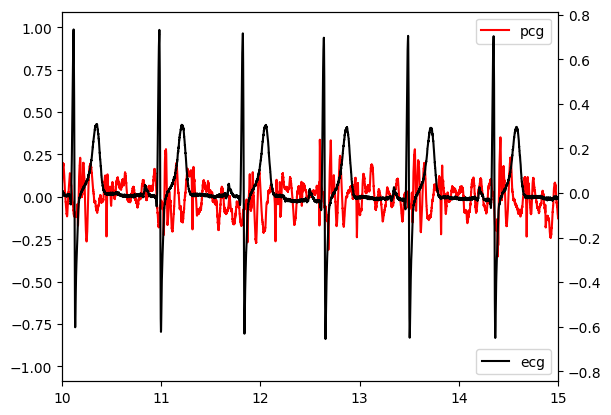

In [7]:
# check ecg and audio are aligned
fig, ax1 = plt.subplots()
ax1.set_xlim(10, 15)
ax2 = ax1.twinx()

ecg_timestamps = np.array([i / ecg_sample_rate for i in range(len(ecg))])

ax1.plot(aligned_audio_timestamps, audio, color="red", label="pcg")
ax2.plot(ecg_timestamps, ecg, color="black", label="ecg")

ax1.legend()
ax2.legend(loc="lower right")

In [8]:
intervals = find_good_intervals(ecg_peaks)

In [9]:
def flatten_list_of_lists(l):
    return [item for sublist in l for item in sublist]


def flat_map(f, items):
    return flatten_list_of_lists(map(f, items))


s1s = flat_map(
    lambda interval: interval["s1Timings"], heart_sound_annotations_by_intervals
)
s2s = flat_map(
    lambda interval: interval["s2Timings"], heart_sound_annotations_by_intervals
)

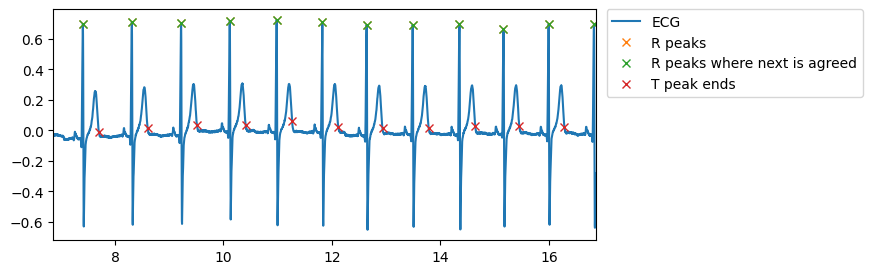

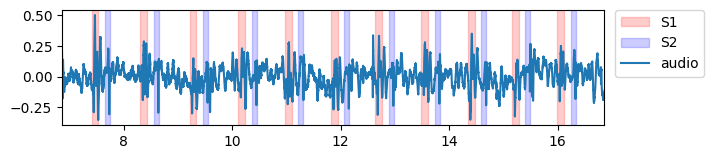

In [10]:
def filter_time_to_within_period(times, period_start, period_end):
    mask = (times >= period_start) & (times <= period_end)
    return times[mask]


def filter_times_and_signal_to_within_period(times, signal, period_start, period_end):
    mask = (times >= period_start) & (times <= period_end)
    return times[mask], signal[mask]


def filter_sounds_to_within_period(sounds, period_start, period_end):
    return [
        (start, end)
        for start, end in sounds
        if start >= period_start and end <= period_end
    ]


time_downsampled = (
    np.arange(len(ecg_peaks.downsampled_signal)) / ecg_peaks.downsampled_sample_rate
)

interval = intervals[
    np.argmax([i["intervalEnd"] - i["intervalStart"] for i in intervals])
]
interval_start_time = interval["intervalStart"]
interval_end_time = interval["intervalEnd"]

duration = 10
middle = (interval_start_time + interval_end_time) / 2
start_time = middle - duration / 2
end_time = middle + duration / 2

r_peaks = filter_time_to_within_period(ecg_peaks.r_peaks, start_time, end_time)
rpeaks_where_next_is_also_agreed = filter_time_to_within_period(
    ecg_peaks.rpeaks_where_next_is_also_agreed, start_time, end_time
)
t_peak_ends = filter_time_to_within_period(ecg_peaks.t_peak_ends, start_time, end_time)

fig, ax = plt.subplots(figsize=(7, 3))

ax.plot(
    *filter_times_and_signal_to_within_period(
        time_downsampled, ecg_peaks.downsampled_signal, start_time, end_time
    ),
    label="ECG"
)

ax.plot(
    r_peaks,
    [
        ecg_peaks.downsampled_signal[np.argmin(np.abs(time_downsampled - t))]
        for t in r_peaks
    ],
    "x",
    label="R peaks",
)
ax.plot(
    rpeaks_where_next_is_also_agreed,
    [
        ecg_peaks.downsampled_signal[np.argmin(np.abs(time_downsampled - t))]
        for t in rpeaks_where_next_is_also_agreed
    ],
    "x",
    label="R peaks where next is agreed",
)
ax.plot(
    t_peak_ends,
    [
        ecg_peaks.downsampled_signal[np.argmin(np.abs(time_downsampled - t))]
        for t in t_peak_ends
    ],
    "x",
    label="T peak ends",
)

ax.set_xlim(start_time, end_time)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

fig, ax = plt.subplots(figsize=(7, 1.5))

for i, (t1, t2) in enumerate(filter_sounds_to_within_period(s1s, start_time, end_time)):
    ax.axvspan(t1, t2, alpha=0.2, color="red", label="S1" if i == 0 else None)

for i, (t1, t2) in enumerate(filter_sounds_to_within_period(s2s, start_time, end_time)):
    ax.axvspan(t1, t2, alpha=0.2, color="blue", label="S2" if i == 0 else None)

ax.plot(
    *filter_times_and_signal_to_within_period(
        audio_timestamps, audio, start_time, end_time
    ),
    label="audio"
)

ax.set_xlim(start_time, end_time)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)